### Group 5 - Youshi Zhang, Gurusankar Gopalakrishnan, Unsupervised Clustering of Sentiment Scores from Reddit Posts Sentiment Scores

ML Objective: 
- Match stock tickers/companies and reddit posts
- Use predicted Reddit posts sentiments to cluster stock tickers

In [0]:
import os
import pandas as pd
import numpy as np
import datetime
import json
import gc

import pyspark
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

import warnings
warnings.filterwarnings('ignore')

In [0]:
spark = SparkSession.builder.getOrCreate()

In [0]:
# REF_STRING = "mongodb+srv://admin:<password>@msds697-cluster.qzgwq.mongodb.net/"
def read_df_from_mongo(spark, collection_name):
    mongo_username = 'admin'
    mongo_password =  'msds697'
    mongo_ip_address = 'msds697-cluster.qzgwq.mongodb.net/'
    MONGO_DB_NAME = "msds697_project"
    connection_string = f"mongodb+srv://{mongo_username}:{mongo_password}@{mongo_ip_address}{MONGO_DB_NAME}.{collection_name}"
    spark_df = spark.read.format("mongo").option("uri", connection_string).load()
    return spark_df
    
def store_df_to_mongo(spark, spark_df, collection_name):
    mongo_username = 'admin'
    mongo_password =  'msds697'
    mongo_ip_address = 'msds697-cluster.qzgwq.mongodb.net/'
    MONGO_DB_NAME = "msds697_project"
    connection_string = f"mongodb+srv://{mongo_username}:{mongo_password}@{mongo_ip_address}{MONGO_DB_NAME}.{collection_name}"
    spark_df.write.format("com.mongodb.spark.sql.DefaultSource")\
                     .mode("append")\
                     .option("uri", connection_string)\
                     .save()

#### Fetch raw sentiment score vectors data from Mongo Atlas

In [0]:
reddit_df = read_df_from_mongo(spark, "sentiment_raw_reddit_vectors2")
reddit_df.printSchema()

root
-- _id: struct (nullable = true)
 |-- oid: string (nullable = true)
-- fulltext: string (nullable = true)
-- id: string (nullable = true)
-- selftext: string (nullable = true)
-- title: string (nullable = true)
-- vectors: array (nullable = true)
 |-- element: array (containsNull = true)
 | |-- element: double (containsNull = true)

In [0]:
# read compnay information
snp_df_raw = read_df_from_mongo(spark, "snp_500_data")
snp_df_raw.printSchema()

root
-- 52 Week High: double (nullable = true)
-- 52 Week Low: double (nullable = true)
-- CIK: double (nullable = true)
-- Date added: string (nullable = true)
-- Dividend Yield: double (nullable = true)
-- EBITDA: double (nullable = true)
-- Earnings/Share: double (nullable = true)
-- Founded: string (nullable = true)
-- GICS Sector: string (nullable = true)
-- GICS Sub-Industry: string (nullable = true)
-- Headquarters Location: string (nullable = true)
-- Market Cap: long (nullable = true)
-- Name: string (nullable = true)
-- Price: double (nullable = true)
-- Price/Book: double (nullable = true)
-- Price/Earnings: double (nullable = true)
-- Price/Sales: double (nullable = true)
-- SEC Filings: string (nullable = true)
-- Sector: string (nullable = true)
-- Security: string (nullable = true)
-- Symbol: string (nullable = true)
-- _id: struct (nullable = true)
 |-- oid: string (nullable = true)
-- state: string (nullable = true)

#### Data Pre-Processing

In [0]:
# turn to pandas dataframe for convenience
snp_df = snp_df_raw.toPandas()

In [0]:
# first match words: company tickers
snp_df['match1'] = snp_df['Symbol']

In [0]:
# second match words: compnay name
# remove stop words from company. The stopwords are inspired by ChatGPT
STOP_WORDS = ['company','corp.','laboratories','inc.','plc.','plc','technologies','energy','corporation','corp','group',"holdings","solutions","services","international","global","systems","technologies","enterprises","management","capital","partners","investments","consulting","development","corporation","company","enterprises","ventures","holdings","limited","private","industries","associates","association","network","project","initiative","foundation","institute","organization",'org.',"inc"]

# define a function
def company_name_clean(x, STOP_WORDS=STOP_WORDS):
    x2 = x.lower().strip()
    for a in STOP_WORDS:
        x2 = x2.replace(a, '')
    x2 = x2.strip()
    return x2

snp_df['match2'] = snp_df['Name'].apply(lambda x: company_name_clean(x))

In [0]:
snp_df.head(1)

,52 Week High,52 Week Low,CIK,Date added,Dividend Yield,EBITDA,Earnings/Share,Founded,GICS Sector,GICS Sub-Industry,Headquarters Location,Market Cap,Name,Price,Price/Book,Price/Earnings,Price/Sales,SEC Filings,Sector,Security,Symbol,_id,state,match1,match2
0,175.49,259.77,66740.0,1957-03-04,2.332862,9.048000e+09,7.92,1902,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",138721055226,3M Company,222.89,11.34,24.31,4.390271,http://www.sec.gov/cgi-bin/browse-edgar?action...,Industrials,3M,MMM,{'oid': '640bcd5fc23625a7f24b27e5'},Minnesota,MMM,3m


In [0]:
# create matching dictionary: if the post hits the words, then it counts as matching the company
matching_dict = {}
for i, row in snp_df.iterrows():
    ticker = row["Symbol"]
    matching_dict[ticker] = []
    if len(row['match1'])>3: # do not include ticker name too short
        matching_dict[ticker].append(row['match2'])
        matching_dict[ticker].append(row['match1'])
    else:
        matching_dict[ticker].append(row['match2'])

# manual fix for some company
matching_dict["AMZN"].append("amazon")
matching_dict["GOOG"].append('alphabet')
matching_dict["GOOGL"].append('alphabet')

In [0]:
# match with reddit posts
def match_reddit_post(x):
    matched = []
    text = x.strip().lower()
    for k,v in matching_dict.items():
        for i in range(len(v)):
            for v[i] in text:
                matched.append(k)
                break
    if len(matched) == 0:
        matched = None
    return matched
match_reddit_post_ = udf(match_reddit_post)
reddit_df = reddit_df.withColumn("matched_all", match_reddit_post_("fulltext"))
reddit_df.select("matched_all").show(5)

+--------------------+
 matched_all|
+--------------------+
[MMM, AOS, ABT, A...|
[MMM, AOS, ABT, A...|
[MMM, AOS, ABT, A...|
[MMM, AOS, ABT, A...|
[MMM, AOS, ABT, A...|
+--------------------+
only showing top 5 rows

In [0]:
# collect sentiment scores for each company
company_sentiment_scores = {}

def collect_scores(row):
    tickers = row['matched_all']
    vector = np.mean(row['vectors'])
    if ticker is not None:
        try:
            for ticker in tickers:
                if ticker in company_sentiment_scores:
                    company_sentiment_scores[ticker].append(vectors)
                else:
                    company_sentiment_scores[ticker] = []
                    company_sentiment_scores[ticker].append(vectors)
        except:
            print(tickers)
            print(ticker)
    else:
        continue
reddit_df.foreach(collect_scores)

#### Unsupervised KMeans using Spark ML

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

The preprocessing result has been saved to MongoDB collection named "reddit_post_sentiment_to_tickers". To standarized the result across the team, the following code will just read the MongoDB collection instead of relying on the codes above.

In [0]:
# read dataframe
cluster_df = read_df_from_mongo(spark, "reddit_post_sentiment_to_tickers").drop("ticker_small","_id")
cluster_df.show(2)

+------+-------------------------+------------------------+-------------------------+
Symbol|negative_sentiment_reddit|neutral_sentiment_reddit|positive_sentiment_reddit|
+------+-------------------------+------------------------+-------------------------+
 GOOGL| 0.2134772323575154| 0.6720852583247926| 0.1144407541255434|
 GOOG| 0.207556259084261| 0.6761723574404802| 0.1162736969260437|
+------+-------------------------+------------------------+-------------------------+
only showing top 2 rows

In [0]:
# vectorize to feature
assembler = VectorAssembler(inputCols=["positive_sentiment_reddit","negative_sentiment_reddit","neutral_sentiment_reddit"], outputCol="features")
cluster_df = assembler.transform(cluster_df)
cluster_df.show(2)

+------+-------------------------+------------------------+-------------------------+--------------------+
Symbol|negative_sentiment_reddit|neutral_sentiment_reddit|positive_sentiment_reddit| features|
+------+-------------------------+------------------------+-------------------------+--------------------+
 GOOGL| 0.2134772323575154| 0.6720852583247926| 0.1144407541255434|[0.11444075412554...|
 GOOG| 0.207556259084261| 0.6761723574404802| 0.1162736969260437|[0.11627369692604...|
+------+-------------------------+------------------------+-------------------------+--------------------+
only showing top 2 rows

##### silhouette scores for different cluster sizes

In [0]:
silhouettes = []
for i in range(2,21):
    bkm = BisectingKMeans(k=i,featuresCol='features')
    model = bkm.fit(cluster_df)
    cluster_sizes = model.summary.clusterSizes
    silhouette = ClusteringEvaluator(featuresCol='features').evaluate(model.transform(cluster_df).select('features','prediction'))
    silhouettes += [ (i, cluster_sizes, silhouette) ]
    print('Clusters: {}, Cluster Size: {}, Silhouette: {}'.format(i, cluster_sizes, np.around(silhouette,4)))
    
results_pd = pd.DataFrame(silhouettes, columns=['n', 'cluster_sizes', 'silhouette'])
display(results_pd)

n,cluster_sizes,silhouette
2,"List(129, 105)",0.5199671993451496
3,"List(102, 27, 105)",0.5980601885391768
4,"List(27, 102, 60, 45)",0.40836491192571933
5,"List(27, 19, 83, 60, 45)",0.5494728403371208
6,"List(27, 19, 83, 15, 45, 45)",0.4704519694002087
7,"List(27, 19, 83, 15, 45, 26, 19)",0.45217089368537045
8,"List(8, 19, 83, 19, 15, 45, 26, 19)",0.4860254226550843
9,"List(8, 19, 33, 50, 19, 15, 45, 26, 19)",0.5325198528807846
10,"List(8, 19, 33, 50, 19, 15, 13, 32, 26, 19)",0.5064984585003461
11,"List(8, 19, 33, 50, 19, 15, 13, 32, 11, 15, 19)",0.477359237822969


####### K=5 is the best cluster

In [0]:
bkm = BisectingKMeans(k=5,featuresCol='features')
model = bkm.fit(cluster_df)
cluster_df = model.transform(cluster_df)
silhouette = ClusteringEvaluator(featuresCol='features')\
                .evaluate(cluster_df.select('features','prediction'))
print('Silhouette score: ', silhouette)

Silhouette score: 0.5494728403371208

###### Silhouette score:  0.549 with K=5.
Cluster sizes = [27, 19, 83, 60, 45]

In [0]:
plot_df = cluster_df.toPandas()

#### Vizualizing these clusters

In [0]:
%pip install plotly-express

Python interpreter will be restarted.
Collecting plotly-express
 Downloading plotly_express-0.4.1-py2.py3-none-any.whl (2.9 kB)
Collecting plotly>=4.1.0
 Downloading plotly-5.13.1-py2.py3-none-any.whl (15.2 MB)
Requirement already satisfied: pandas>=0.20.0 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (1.0.1)
Requirement already satisfied: scipy>=0.18 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (1.4.1)
Requirement already satisfied: patsy>=0.5 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (0.5.1)
Requirement already satisfied: numpy>=1.11 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (1.18.1)
Requirement already satisfied: statsmodels>=0.9.0 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (0.11.0)
Collecting tenacity>=6.2.0
 Downloading tenacity-8.2.2-py3-none-any.whl (24 kB)
Requirement already satisfied: python-dateutil>=2.6.1 in /databricks/python3/lib/python3.7/site-packages (from pandas>=0.20.0->plotly-express) (2.8.1)
Requirement already satisfied: pytz>=2017.2 in /databricks/python3/lib/python3.7/site-packages (from pandas>=0.20.0->plotly-express) (2019.3)
Requirement already satisfied: six in /databricks/python3/lib/python3.7/site-packages (from patsy>=0.5->plotly-express) (1.14.0)
Installing collected packages: tenacity, plotly, plotly-express
 Attempting uninstall: plotly
 Found existing installation: plotly 2.0.7
 Not uninstalling plotly at /databricks/python3/lib/python3.7/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-962783c3-6874-4f64-b15e-3ae6474c3d4d
 Can't uninstall 'plotly'. No files were found to uninstall.
Successfully installed plotly-5.13.1 plotly-express-0.4.1 tenacity-8.2.2
WARNING: You are using pip version 20.0.2; however, version 23.0.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-962783c3-6874-4f64-b15e-3ae6474c3d4d/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
%pip install packaging

Python interpreter will be restarted.
Collecting packaging
 Downloading packaging-23.0-py3-none-any.whl (42 kB)
Installing collected packages: packaging
Successfully installed packaging-23.0
WARNING: You are using pip version 20.0.2; however, version 23.0.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-962783c3-6874-4f64-b15e-3ae6474c3d4d/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
import plotly.express as px

# Create the 2D scatter plot
fig = px.scatter(plot_df, 
                 x='positive_sentiment_reddit', 
                 y='negative_sentiment_reddit',
                 color='prediction')

# Show the plot
fig.show()


In [0]:
# Create the 2D scatter plot
fig = px.scatter(plot_df, 
                 x='positive_sentiment_reddit', 
                 y='neutral_sentiment_reddit',
                 color='prediction')

# Show the plot
fig.show()

In [0]:
# Create the 2D scatter plot
fig = px.scatter(plot_df, 
                 x='negative_sentiment_reddit', 
                 y='neutral_sentiment_reddit',
                 color='prediction')

# Show the plot
fig.show()

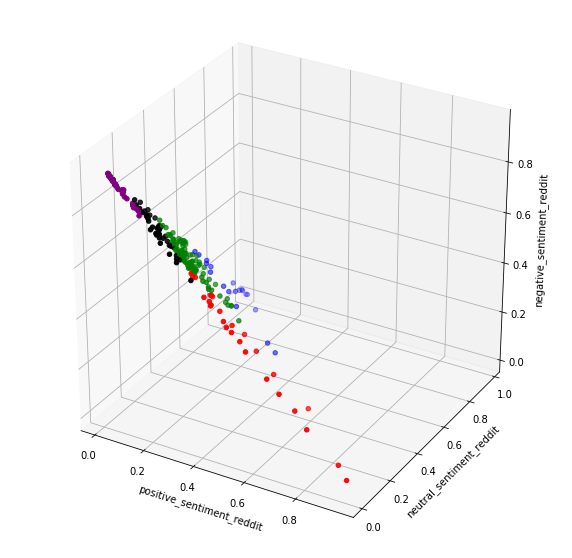

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# load dataframe
df = plot_df

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Set the x, y, and z axis labels
ax.set_xlabel('positive_sentiment_reddit')
ax.set_zlabel('negative_sentiment_reddit')
ax.set_ylabel('neutral_sentiment_reddit')

# Define the color map
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'black'}
df['color'] = df['prediction'].map(colors)

# Add the data points to the plot
ax.scatter( df['positive_sentiment_reddit'], df['negative_sentiment_reddit'], df['neutral_sentiment_reddit'],
           c=df['color'], marker='o')

# Show the plot
plt.show()
